<a href="https://colab.research.google.com/github/bensarthou/pytorch-tutorial/blob/master/ROB313_TP3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# I - Installation and standards functions

In this part, we install the needed library, download the data and define some useful functions for the next part

In [0]:
from __future__ import print_function, division

import itertools
import time
import numpy as np
import matplotlib.pyplot as plt

In [0]:
%matplotlib inline
# Python 2/3 compatibility


# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

1) Install Torch, PyTorch and TorchVision

In [3]:
!pip install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip install torchvision

    100% |████████████████████████████████| 512.6MB 49.2MB/s 
tcmalloc: large alloc 1073750016 bytes == 0x58dd2000 @  0x7f5542cbe2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 61kB 2.4MB/s 
    100% |████████████████████████████████| 2.0MB 12.3MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


2) Define CUDA device for GPU acceleration

In [0]:
import torch as th
import torch
import torchvision
import torchvision.transforms as transforms

seed = 42
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")


3) Download data, pre-process it and split into a train, validation and test set

In [5]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

num_workers = 2
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = th.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = th.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [0]:
#@title ROB313 - Classifying CIFAR10 with Deep Learning


# II -  Define the NN functions

In [0]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

  
def createLossAndOptimizer(net, loss, opti, weight_decay, learning_rate):
  """ Define a loss function, and an optimizer from PyTorch 
      with the needed parameters
      
      @param:
          net: NN class from PyTorch, define a Neural Net
          loss: string, loss function name
          opti: string, optimizer name
          weight_decay: float, L2 regularization, if not 0.0
          learning_rate: float, decay of gradient
      
      @return:
          criterion: Loss function to be optimized from PyTorch
          optimizer: optimizer from PyTorch for gradient descent       
      """
  
  if loss=='L1':
    criterion = nn.L1Loss()
  elif loss=='MSE':
    criterion = nn.MSELoss()
  elif loss=='cross-entropy':
    criterion = nn.CrossEntropyLoss()
  elif loss=='NLL':
    criterion = nn.NLLLoss()
  else:
    print('Loss function not implemented yet')
    raise(ValueError)

    
  if opti=='Adam':
    if weight_decay != 0.0:
      optimizer = optim.Adam(net.parameters(), lr=learning_rate,
                             weight_decay=weight_decay)    
    else:
      optimizer = optim.Adam(net.parameters(), lr=learning_rate)    

  elif opti=='RMS':
    if weight_decay != 0.0:
      optimizer = optim.RMSprop(net.parameters(), lr=learning_rate,
                                weight_decay=weight_decay)    
    else:
      optimizer = optim.RMSprop(net.parameters(), lr=learning_rate)    

  elif opti=='SGD':
    if weight_decay != 0.0:
      optimizer = optim.SGD(net.parameters(), lr=learning_rate,
                            weight_decay=weight_decay)    
    else:
      optimizer = optim.SGD(net.parameters(), lr=learning_rate)    

  else:
    print('Optimizer not implemented yet')
    raise(ValueError)    

    
  return criterion, optimizer

Define function for loading data, according to BATCH_SIZE

In [0]:
BATCH_SIZE_VAL = 128

def get_train_loader(batch_size):
    return th.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = th.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_VAL, sampler=val_sampler,
                                          num_workers=num_workers)



Define train function, with hyperparameters

In [0]:
def train(net, batch_size, n_epochs, learning_rate, loss='cross-entropy',
          opti='Adam', weight_decay=0.0, verbose=True):
    """
    Train a neural network and print statistics of the training
    
    :param  net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("loss=", loss)
    print("opti=", opti)
    print("weight_decay=", weight_decay)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, loss, opti, weight_decay,
                                                  learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)

            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()
            
            if verbose:
              # print every 10th of epoch
              if (i + 1) % (print_every + 1) == 0:    
                  print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                        epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                        time.time() - start_time))
                  running_loss = 0.0
                  start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

Define functions for evaluating performance: Accuracy, Confusion matrix

In [0]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))
    return accuracy

def train_set_accuracy(net):
    acc = dataset_accuracy(net, train_loader, "train")
    return acc
  
def val_set_accuracy(net):
    acc = dataset_accuracy(net, val_loader, "validation")  
    return acc
  
def test_set_accuracy(net):
    acc = dataset_accuracy(net, test_loader, "test")
    return acc

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)
    

def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix


Help for CNN shapes

In [0]:
def get_output_size(in_size, kernel_size, stride=1, padding=0):
    """
    Get the output size given all the parameters of the convolution
    :param in_size: (int) input size
    :param kernel_size: (int)
    :param stride: (int)
    :param paddind: (int)
    :return: (int)
    """
    return int((in_size - kernel_size + 2 * padding) / stride) + 1

# III - Create a CNN and run it, then test it

## 1) Create the Net

### a) ConvNet

In [0]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        # Size of the output of the last convolution:
        self.flattened_size = 18 * 16 * 16
        ### END CODE ###
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)
        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        # 18x16x16 -> 4608
        x = x.view(-1, self.flattened_size)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x

### b) SimpleNet

In [0]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        

        #### START CODE: ADD NEW LAYERS ####
        # (do not forget to update `flattened_size`:
        # the input size of the first fully connected layer self.fc1)
        # self.conv2 = ...

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv1_bn = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)                
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4_bn = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5_bn = nn.BatchNorm2d(128)
        # Add Max Pooling
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv6_bn = nn.BatchNorm2d(128)
        self.conv7 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv7_bn = nn.BatchNorm2d(128)
        self.conv8 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv8_bn = nn.BatchNorm2d(128)
        # Add Max Pooling
        self.conv9 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv9_bn = nn.BatchNorm2d(128)
        self.conv10 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv10_bn = nn.BatchNorm2d(128)
        # Add Max Pooling
        self.conv11 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv11_bn = nn.BatchNorm2d(128)                
        self.conv12 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
        self.conv12_bn = nn.BatchNorm2d(128)
        self.conv13 = nn.Conv2d(128, 128, kernel_size=1, stride=1, padding=0)
        self.conv13_bn = nn.BatchNorm2d(128)
        # Add MaxPooling
        self.conv14 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv14_bn = nn.BatchNorm2d(128)

        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
                
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 2 * 2

        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 64x32x32
        x = F.relu(self.conv1_bn(self.conv1(x)))
        # 64x32x32 -> 128x32x32        
        x = F.relu(self.conv2_bn(self.conv2(x)))
        # 128x16x16 -> 128x32x32        
        x = F.relu(self.conv3_bn(self.conv3(x)))
        # 128x16x16 -> 128x32x32        
        x = F.relu(self.conv4_bn(self.conv4(x)))
        # 128x32x32 -> 128x16x16        
        x = F.relu(F.max_pool2d(self.conv5_bn(self.conv5(x)), 2))

        # 128x16x16 -> 128x16x16        
        x = F.relu(self.conv6_bn(self.conv6(x)))
        # 128x16x16 -> 128x16x16        
        x = F.relu(self.conv7_bn(self.conv7(x)))
        # 128x16x16 -> 128x8x8        
        x = F.relu(F.max_pool2d(self.conv8_bn(self.conv8(x)), 2))

        # 128x8x8 -> 128x8x8        
        x = F.relu(self.conv9_bn(self.conv9(x)))
        # 128x8x8 -> 128x4x4        
        x = F.relu(F.max_pool2d(self.conv10_bn(self.conv10(x)), 2))

        # 128x4x4 -> 128x4x4        
        x = F.relu(self.conv11_bn(self.conv11(x)))
        # 128x4x4 -> 128x4x4 with Conv(kernel=1, stride=1, padding=0)       
        x = F.relu(self.conv12_bn(self.conv12(x)))
        # 128x4x4 -> 128x2x2 with Conv(kernel=1, stride=1, padding=0)       
        x = F.relu(F.max_pool2d(self.conv13_bn(self.conv13(x)), 2))
        
        # 128x2x2 -> 128x2x2 with Conv(kernel=3, stride=1, padding=0)       
        x = F.relu(self.conv14_bn(self.conv14(x)))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
        # 18x16x16 -> 4608
        x = x.view(-1, self.flattened_size)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        x = self.fc2(x)
        return x
      
 

### c) ConvDepth

In [0]:
class ConvDepth2(nn.Module):
    def __init__(self):
        super(ConvDepth2, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 32 * 32
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x32x32
        x = F.relu(self.conv1(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv2(x))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
class ConvDepth4(nn.Module):
    def __init__(self):
        super(ConvDepth4, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 32 * 32
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x32x32
        x = F.relu(self.conv1(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv2(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv3(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv4(x))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
class ConvDepth6(nn.Module):
    def __init__(self):
        super(ConvDepth6, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 32 * 32
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x32x32
        x = F.relu(self.conv1(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv2(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv3(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv4(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv5(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv6(x))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### d) Feature compression

In [0]:
class NoCompression(nn.Module):
    def __init__(self):
        super(NoCompression, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 32 * 32
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x32x32
        x = F.relu(self.conv1(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv2(x))
        # shape : 128x32x32 -> 128x32x32
        x = F.relu(self.conv3(x))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
class Compression(nn.Module):
    def __init__(self):
        super(Compression, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 4 * 4
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x16x16
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        # shape : 128x16x16 -> 128x8x8
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        # shape : 128x8x8 -> 128x4x4
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### e) Vanishing Gradient and activation function

In [0]:
class Sigmoid(nn.Module):
    def __init__(self):
        super(Sigmoid, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 4 * 4
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x16x16
        x = F.sigmoid(F.max_pool2d(self.conv1(x), 2))
        # shape : 128x16x16 -> 128x8x8
        x = F.sigmoid(F.max_pool2d(self.conv2(x), 2))
        # shape : 128x8x8 -> 128x4x4
        x = F.sigmoid(F.max_pool2d(self.conv3(x), 2))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
class SoftShrink(nn.Module):
    def __init__(self):
        super(SoftShrink, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 4 * 4
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x16x16
        x = F.softshrink(F.max_pool2d(self.conv1(x), 2))
        # shape : 128x16x16 -> 128x8x8
        x = F.softshrink(F.max_pool2d(self.conv2(x), 2))
        # shape : 128x8x8 -> 128x4x4
        x = F.softshrink(F.max_pool2d(self.conv3(x), 2))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [0]:
class Elu(nn.Module):
    def __init__(self):
        super(Elu, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 4 * 4
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x16x16
        x = F.elu(F.max_pool2d(self.conv1(x), 2))
        # shape : 128x16x16 -> 128x8x8
        x = F.elu(F.max_pool2d(self.conv2(x), 2))
        # shape : 128x8x8 -> 128x4x4
        x = F.elu(F.max_pool2d(self.conv3(x), 2))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### f) Regularization

In [0]:
class Dropout(nn.Module):
    def __init__(self):
        super(Dropout, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        
        self.dropout1 = nn.Dropout2d(0.8)
        self.dropout2 = nn.Dropout2d(0.8)
        self.dropout3 = nn.Dropout2d(0.8)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 4 * 4
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x16x16
        x = F.max_pool2d(self.dropout1(F.elu(self.conv1(x))), 2)
        # shape : 128x16x16 -> 128x8x8
        x = F.max_pool2d(self.dropout2(F.elu(self.conv2(x))), 2)
        # shape : 128x8x8 -> 128x4x4
        x = F.max_pool2d(self.dropout3(F.elu(self.conv3(x))), 2)

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### g) More ideas

In [0]:
class Extension(nn.Module):
    def __init__(self):
        super(Extension, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        
        # Size of the output of the last convolution:
        self.flattened_size = 512 * 4 * 4
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 128x16x16
        x = F.elu(F.max_pool2d(self.conv1(x), 2))
        # shape : 128x16x16 -> 128x8x8
        x = F.elu(F.max_pool2d(self.conv2(x), 2))
        # shape : 128x8x8 -> 128x4x4
        x = F.elu(F.max_pool2d(self.conv3(x), 2))

        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### ?) - CConvNet

In [0]:
# inspired from the Cuda Conv Net:
# Use with: lr=0.001, batch_size=128, epochs=85


class CConvNet(nn.Module):
    def __init__(self):
        super(CConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=1)# Then Relu, then MaxPool
        self.conv2 = nn.Conv2d(32, 32, kernel_size=5, stride=1, padding=1)# Then Relu, then MaxPool
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1)# Then Relu, then MaxPool
        
        # Size of the output of the last convolution:
        self.flattened_size = 16 * 4 * 4
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 32x16x16
        x = F.max_pool2d(F.relu(self.conv1(x)),2)
        #print(x.size())
        # shape : 32x16x16 -> 32x8x8
        x = F.max_pool2d(F.relu(self.conv2(x)),2)
        #print(x.size())
        # shape : 32x8x8 -> 32x4x4
        x = F.max_pool2d(F.relu(self.conv3(x)),2)
        #print(x.size())
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)

        # Flatten and output
        x = x.view(-1, self.flattened_size)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## 2) Train the network

In [0]:
net = ConvNet()
#train_history, val_history = train(net, batch_size=32, n_epochs=5,
#                                   learning_rate=0.001, loss='cross-entropy',
#                                   opti='Adam', weight_decay=0.2, verbose=False)

## 3) Evaluate performance

### a) Plot losses

In [25]:
plot_losses(train_history, val_history)

NameError: ignored

### b) Accuracy 

In [0]:
compute_accuracy(net)

### c) Confusion Matrix

In [0]:
confusion_matrix = accuracy_per_class(net)
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

# IV - Impact of hyperparameters

In this part, we will evaluate, on a simple model, the impact of learning rate, batch size, the choice of the optimizer and the loss function. 

In [0]:
def gridsearch(params):
  
  res = []
  for opti_value in params['opti']:
    for loss_value in params['loss']:
      for lr_value in params['lr']:
        for batch_size_value in params['batch_size']:
          net = ConvNet()
          train_history, val_history = train(net, batch_size=batch_size_value,
                                             n_epochs=5, learning_rate=lr_value,
                                             loss=loss_value, opti=opti_value,
                                             weight_decay=0.0, verbose=False)
          accuracy = test_set_accuracy(net)
          
          res.append([opti_value, loss_value, lr_value,
                      batch_size_value, accuracy])
          
  return res

In [0]:
params = {'opti':['SGD'], #Adam and RMS gives terrible results, don't know why
          'loss':['cross-entropy'], #Others are more adapted to regression than classification
          'lr':[1.0, 0.5, 0.1, 0.001, 0.0001],
          'batch_size':[16, 32, 64]}

results = gridsearch(params)
print(results)

In [0]:
plt.figure()
#plt.subplot(121)
plt.title('Evolution of accuracy with batch size')

res = np.array(results)

for lr in [1.0, 0.5, 0.1, 0.001, 0.0001]:
  for loss in ['cross-entropy', 'NLL']:
    res1 = res[res[:,1]==loss, :]
    res2 = res1[res1[:,2]==str(lr), :]  
    acc, bs = res2[:,4].astype(float), res2[:,3]

    label='opti={}; lr={}; loss={}'.format('SGD', lr, loss)
    plt.plot(bs, acc, label=label)  

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



In [0]:
plt.figure()
#plt.subplot(122)
plt.title('Evolution of accuracy with learning rate')

res = np.array(results)

for batch_size in [16, 32, 64]:
  for loss in ['cross-entropy', 'NLL']:
    res1 = res[res[:,1]==loss, :]
    res2 = res1[res1[:,3]==str(batch_size), :]  
    acc, lr = res2[:,4].astype(float), res2[:,2]

    label='opti={}; batch_size={}; loss={}'.format('SGD', batch_size, loss)
    plt.plot(lr, acc, label=label)  

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.tight_layout()
plt.show()

# V - Testing architecture impact

## 1) Depth

In [0]:
net1 = ConvDepth2()
net2 = ConvDepth4()
net3 = ConvDepth6()


for net in [net1, net2, net3]:

  train_history, val_history = train(net, batch_size=32, n_epochs=7,
                                     learning_rate=0.01, loss='cross-entropy',
                                     opti='SGD', weight_decay=0.0, verbose=False)
  plot_losses(train_history, val_history)
  test_set_accuracy(net)

## 2) Feature compression

In [0]:
net_with_compression = Compression()
net_wo_compression = NoCompression()

for net in [net_with_compression, net_wo_compression]:
  train_history, val_history = train(net, batch_size=32, n_epochs=15,
                                     learning_rate=0.01, loss='cross-entropy',
                                     opti='SGD', weight_decay=0.0, verbose=False)
  plot_losses(train_history, val_history)
  test_set_accuracy(net)
  

## 3) Activation function

In [0]:
net1 = Compression()
net2 = Sigmoid()
net3 = SoftShrink()
net4 = Elu()


for net in [net1, net2, net3, net4]:

  train_history, val_history = train(net, batch_size=32, n_epochs=7,
                                     learning_rate=0.01, loss='cross-entropy',
                                     opti='SGD', weight_decay=0.0, verbose=False)
  plot_losses(train_history, val_history)
  test_set_accuracy(net)

## 4) Regularization

In [0]:
# First technique: Adding regularization factor into the loss function
net = Elu()

train_history, val_history = train(net, batch_size=32, n_epochs=60,
                                   learning_rate=0.01, loss='cross-entropy',
                                   opti='SGD', weight_decay=0.03, verbose=False)
plot_losses(train_history, val_history)
test_set_accuracy(net)

In [0]:
# Second technique: Use dropout layer to "avoid" training some neurons during learning 
net = Dropout()

train_history, val_history = train(net, batch_size=16, n_epochs=60,
                                   learning_rate=0.01, loss='cross-entropy',
                                   opti='SGD', weight_decay=0.0, verbose=False)
plot_losses(train_history, val_history)
test_set_accuracy(net)

## 5) Literature models

In [0]:
net = SimpleNet()

train_history, val_history = train(net, batch_size=64, n_epochs=20,
                                   learning_rate=0.01, loss='cross-entropy',
                                   opti='SGD', weight_decay=0.0, verbose=False)
plot_losses(train_history, val_history)
test_set_accuracy(net)


In [0]:
net = CConvNet()

train_history, val_history = train(net, batch_size=64, n_epochs=100,
                                   learning_rate=0.005, loss='cross-entropy',
                                   opti='SGD', weight_decay=0.0, verbose=False)
plot_losses(train_history, val_history)
test_set_accuracy(net)


===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 25
learning_rate= 0.01
loss= cross-entropy
opti= SGD
weight_decay= 0.0
Validation loss = 2.04
Validation loss = 1.73
Validation loss = 1.62
Validation loss = 1.47
Validation loss = 1.51
Validation loss = 1.34
Validation loss = 1.30
Validation loss = 1.35
Validation loss = 1.19
Validation loss = 1.17
Validation loss = 1.11
Validation loss = 1.08
Validation loss = 1.05
Validation loss = 1.08
Validation loss = 0.97
Validation loss = 0.99
Validation loss = 0.95
Validation loss = 0.96
Validation loss = 0.92
Validation loss = 0.90
Validation loss = 0.92
Validation loss = 0.92
Validation loss = 0.93
Validation loss = 0.96
Validation loss = 0.99
Training Finished, took 251.29s


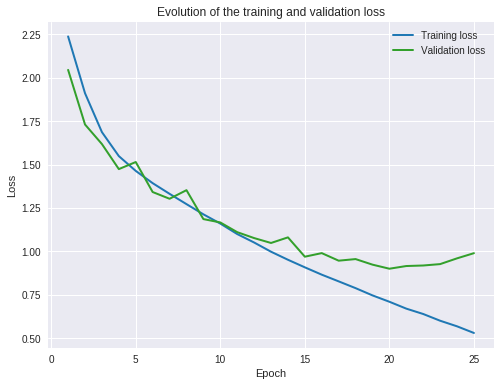

Accuracy of the network on the 5000 test images: 68.60 %
Class      Accuracy (%)
plane        73.16   
car          85.74   
bird         48.05   
cat          50.70   
deer         55.23   
dog          63.11   
frog         76.99   
horse        82.02   
ship         81.15   
truck        70.37   


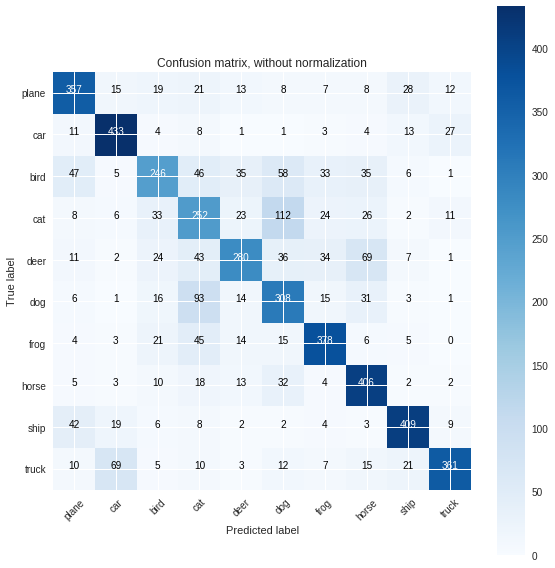

In [26]:
# Best model

net = Compression()

train_history, val_history = train(net, batch_size=32, n_epochs=25,
                                   learning_rate=0.01, loss='cross-entropy',
                                   opti='SGD', weight_decay=0.0, verbose=False)
plot_losses(train_history, val_history)
test_set_accuracy(net)

confusion_matrix = accuracy_per_class(net)
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

# VI - Data augmentation

In [0]:
# Re-run this cell before training another model
from torch.utils.data.sampler import SubsetRandomSampler

rgb_mean = (0.4914, 0.4822, 0.4465)
rgb_std = (0.2023, 0.1994, 0.2010)


n_training_samples = 20000 # Max: 50 000 - n_val_samples
n_val_samples = 5000
n_test_samples = 5000

train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))

num_workers = 2
test_batch_size = 4

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(rgb_mean, rgb_std),
])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = th.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = th.utils.data.DataLoader(test_set, batch_size=test_batch_size, sampler=test_sampler,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')